**Avatars IDs**

- Mens US ASTM Sz M/40, MALE ID: "b4ec391f-4a63-41ad-8efd-f3e45c75bb28"

- Womens US ASTM Sz M/6, FEMALE ID: "ad80d4fd-cf03-4337-b42a-8df04ea07bcc"

# *Compute new positions of the garment*

In [1]:
import json
import math

#IMPORT SCENE
rute = 'store_state_transformed.json'

with open(rute) as archivo:
    data = json.load(archivo)

# Avatar & Pieces geometry data
avatar = data["avatar"]
pieces = data["pieces"]

#print("Avatar", avatar)

all_pieces_indices = []
all_pieces_position3d = []
all_pieces_position2d = []

all_sewLines = []
all_pieces_position2d = []

# Rotation
def rotate_point(x, y, theta):
    x_rotated = x * math.cos(theta) - y * math.sin(theta)
    y_rotated = x * math.sin(theta) + y * math.cos(theta)
    return x_rotated, y_rotated

for piece in data['pieces']:
    indices = piece['components']['garmentPiece']['geometry']['indices']
    position3D = piece['components']['garmentPiece']['geometry']['position3D']
    position2D = piece['components']['garmentPiece']['geometry']['position2D']    
    # Ajusta la rotación a pi/2 o -pi/2
    if round(piece['components']['transform2D']['rotation'] / (math.pi / 2)) * (math.pi / 2) > 0:
        rotation = math.pi / 2
    else:
        rotation = -math.pi / 2

    translation = piece['components']['transform2D']['translation']
    sewLine = piece['components']['garmentPiece']['sewLine']['path']    

    all_pieces_indices.extend(indices)
    all_pieces_position3d.extend(position3D)

    #GET PIECE 2D COORDINATES ROTATED & TRANSLATED
    for i in range(0, len(position2D), 2):

        x = position2D[i]
        y = position2D[i + 1]
        
        # Rotation
        x_rotated, y_rotated = rotate_point(x, y, rotation)

        # Translation
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        
        # Update 2d coordinates
        position2D[i] = x_translated
        position2D[i + 1] = y_translated
    all_pieces_position2d.append({'garmentPiece_id': piece['_id'], 'position2D': position2D})

    for point in sewLine:
        x = point['position']['x']
        y = point['position']['y']
        
        # Rotar el punto
        x_rotated, y_rotated = rotate_point(x, y, rotation)
        
        # Aplicar translación
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        
        # Actualizar las coordenadas del punto
        point['position']['x'] = x_translated
        point['position']['y'] = y_translated
        if 'control1' in point:
            # Rotar el punto de control1
            x_c1 = point['control1']['x']
            y_c1 = point['control1']['y']
            x_rotated_c1, y_rotated_c1 = rotate_point(x_c1, y_c1, rotation)
            
            # Aplicar translación al punto de control1 rotado
            x_translated_c1 = x_rotated_c1 + translation['x']
            y_translated_c1 = y_rotated_c1 + translation['y']
            
            # Actualizar las coordenadas del punto de control1
            point['control1']['x'] = x_translated_c1
            point['control1']['y'] = y_translated_c1

        if 'control2' in point:
            # Rotar el punto de control2
            x_c2 = point['control2']['x']
            y_c2 = point['control2']['y']
            x_rotated_c2, y_rotated_c2 = rotate_point(x_c2, y_c2, rotation)
            
            # Aplicar translación al punto de control2 rotado
            x_translated_c2 = x_rotated_c2 + translation['x']
            y_translated_c2 = y_rotated_c2 + translation['y']
            
            # Actualizar las coordenadas del punto de control2
            point['control2']['x'] = x_translated_c2
            point['control2']['y'] = y_translated_c2
    all_sewLines.append({'garmentPiece_id': piece['_id'], 'sewLine': sewLine})


transformed_poms = []

# ALL POMS TRANSFORMED POSITIONS
for pom in data["poms"]:

    garment_piece_id = pom["garmentPieceId"]

    # TRANSFORM associated with pom
    for piece in data['pieces']:
        if piece['_id'] == garment_piece_id:
            rotation = piece['components']['transform2D']['rotation']
            translation = piece['components']['transform2D']['translation']
            break

    # POM COORDS
    pom_coords = [(point["position"]["x"], point["position"]["y"]) for point in pom["position"]["_path"]]
    transformed_pom_coords = []
    for x, y in pom_coords:
        # Rotation
        x_rotated, y_rotated = rotate_point(x, y, rotation)
        # Translation
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        transformed_pom_coords.append((x_translated, y_translated))
    transformed_poms.append(transformed_pom_coords)
        

print("Pieces", len(all_pieces_position3d)/3)
print("Pieces", all_pieces_position2d)


Pieces 8895.0
Pieces [{'garmentPiece_id': '661c20b39565d2501311a089', 'position2D': [-0.8024697529775202, 1.652154212584481, -0.812469743440777, 1.652154212584481, -0.8224697488051951, 1.652154212584481, -0.8324697541696131, 1.652154212584481, -0.8424697595340311, 1.652154212584481, -0.852469749997288, 1.652154212584481, -0.862469755361706, 1.652154212584481, -0.872469760726124, 1.652154212584481, -0.8824697511893809, 1.652154212584481, -0.8924697565537989, 1.652154212584481, -0.9024697470170557, 1.652154212584481, -0.9124697523814738, 1.652154212584481, -0.9224697502953112, 1.652154212584481, -0.9324697482091486, 1.652154212584481, -0.9424697535735667, 1.652154212584481, -0.9524697440368235, 1.652154212584481, -0.9624697494012415, 1.652154212584481, -0.9724697622162402, 1.652154212584481, -0.982469752679497, 1.652154212584481, -0.9924697505933344, 1.652154212584481, -1.0024697410565913, 1.652154212584481, -1.0124697464210093, 1.652154212584481, -1.0224697517854273, 1.652154212584481, 

In [2]:
import numpy as np

#Convert to numpy arrays & matrix
avatar_indices = np.array(avatar["indices"])
avatar_positions = np.array(avatar["positions"]).reshape(-1, 3)  # 3 colum matrix 

pieces_indices = np.array(all_pieces_indices)
pieces_positions = np.array(all_pieces_position3d).reshape(-1, 3)  # 3 colum matrix 
pieces_positions2d = np.array(all_pieces_position2d)
bezier_2d = np.array(all_sewLines)
pieces_bezierPath = np.array(all_sewLines)

print(bezier_2d)


[{'garmentPiece_id': '661c20b39565d2501311a089', 'sewLine': [{'position': {'x': -0.8024697529775202, 'y': 1.634628211846337}, 'type': 'LINE', '_id': '6601616da0216e4eb0a5a3b9'}, {'position': {'x': -0.8024697529775202, 'y': 1.652154212584481}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3ba'}, {'position': {'x': -1.2324697601300776, 'y': 1.652154212584481}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3bb'}, {'position': {'x': -1.2324697601300776, 'y': 1.634628211846337}, 'type': 'LINE', '_id': '6601616da0216e4eb0a5a3bc'}, {'position': {'x': -1.2324697601300776, 'y': 1.6171022111081932}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3bd'}, {'position': {'x': -0.8024697529775202, 'y': 1.6171022111081932}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3be'}]}
 {'garmentPiece_id': '661c20b39565d2501311a09d', 'sewLine': [{'position': {'x': -0.4455405619973488, 'y': 1.410045785275729}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3c9'}, {'position': {'x': -0.5996812653774567, 'y': 1

In [3]:
# Compute min distances garment-avatar
min_distances = np.zeros(len(pieces_positions))
ac = np.zeros(len(pieces_positions), dtype=int) # Avatar Correspondences

# For all vertex in the garment
for i, pos_prenda in enumerate(pieces_positions):
    dist_vertex = np.linalg.norm(pos_prenda - avatar_positions, axis=1)
    # Find nearest avatar index and compute min distance
    nearest_indice_vertex = np.argmin(dist_vertex)
    min_dist = dist_vertex[nearest_indice_vertex]
    #print(distancias_vertice[indice_vertice_cercano])

    # Save min distances and avatar index correspondences
    min_distances[i] = min_dist
    ac[i] = nearest_indice_vertex



In [4]:
# Offset between garment vertex and its nearest avatar vertex
offsets = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    offset = np.array(pieces_positions[i])- np.array(avatar_positions[indice_avatar])  
    offsets[i]=offset

#print(offsets)



New Avatar

In [5]:
#IMPORT NEW AVATAR
avatars = 'avatars.json'

with open(avatars) as file:
    avatars_data = json.load(file)
new_avatar = avatars_data["male"]

new_avatar_positions= np.array(new_avatar["positions"]).reshape(-1, 3)  # 3d colum matrix


In [6]:
#Compute new pieces positions with the offset computed and its nearest avatar index from the new avatar (Avatars in seddi have the same mesh)
new_pieces_positions = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    new_pieces_positions[i] = np.array(new_avatar_positions[indice_avatar]) + np.array(offsets[i])


#print(new_pieces_positions)


In [7]:
#Export SCENE TO JSON for AUTHOR

import json
#IMPORT SCENE
rute = 'store_state_transformed.json'

with open(rute) as archivo:
    data = json.load(archivo)


pieces = data["pieces"]
new_list_positions = new_pieces_positions.reshape(-1).tolist()

for piece in data['pieces']:
    indices = piece['components']['garmentPiece']['geometry']['indices']
    positions = piece['components']['garmentPiece']['geometry']['position3D']

    # Len atucal piece
    length_piece = len(positions)
    # Get new positions actual piece
    new_positions = new_list_positions[:length_piece]

    # Remplace for new positions
    piece['components']['garmentPiece']['geometry']['position3D'] = new_positions
    
    # Update new_pieces_positions to next piece
    new_list_positions = new_list_positions[length_piece:]

with open("output.json", "w") as outfile: 
      json.dump(data, outfile)
print("Datos exportados a 'output.json'")

Datos exportados a 'output.json'


DEFORMATION METRICS FOR 2D PATTERN

POM: C0: -0.6383009735288347 0.9578646409909573 C1: -0.06359579124865206 0.957861884898801


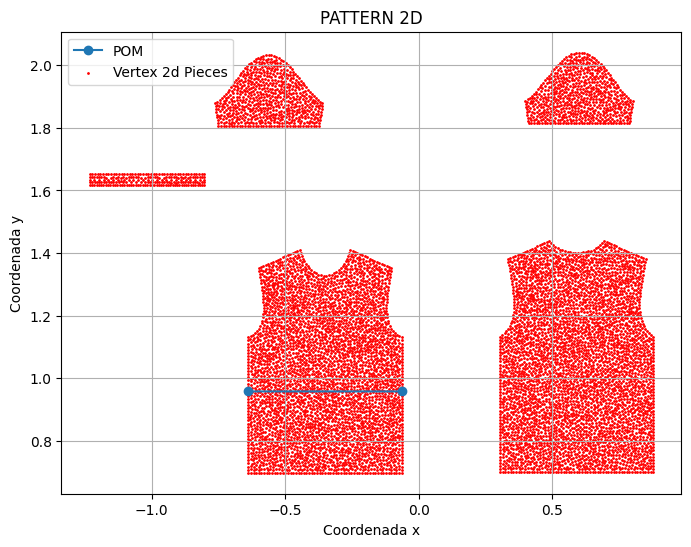

In [8]:
#Vertex defined by POM POINTS
import matplotlib.pyplot as plt


#GET POMS COORDINATES
class Coordinates:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

poms = data["poms"]
#print(transformed_poms[0][0][0])
pom_C0=Coordinates(transformed_poms[0][0][0],transformed_poms[0][0][1])
pom_C1=Coordinates(transformed_poms[0][1][0],transformed_poms[0][1][1])


POM = transformed_poms
print("POM:","C0:",pom_C0.x,pom_C0.y,"C1:",pom_C1.x,pom_C1.y)

#print(pieces_positions2d)
pieces_2d = []
for piece_data in pieces_positions2d:
    position2d = piece_data['position2D']
    for i in range(0, len(position2d), 2):
        x = position2d[i]
        y = position2d[i + 1]
        pieces_2d.append(Coordinates(x, y))


# PLOT
plt.figure(figsize=(8, 6))

plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')


plt.scatter([position.x for position in pieces_2d], 
            [position.y for position in pieces_2d], 
            color='red',s=1, label='Vertex 2d Pieces')


plt.xlabel('Coordenada x')
plt.ylabel('Coordenada y')
plt.title('PATTERN 2D')
plt.legend()

plt.grid(True)
plt.show()





Diferencia en longitudes de aristas entre los dos avatares:


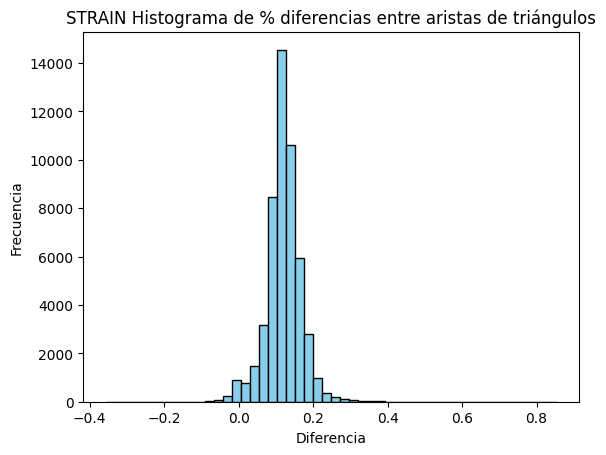

50859


In [9]:
#COMPUTE DEFORMATION METRIC 3D: EDGE LENGTH

def compute_edge_lengths(points, indices):
    edge_lengths = []
    for i in range(0, len(indices), 3):
        # Obtener los índices de los puntos que forman el triángulo
        p1_index, p2_index, p3_index = indices[i], indices[i+1], indices[i+2]

        # Obtener las posiciones 3D de los puntos del triángulo
        p1 = points[p1_index]
        p2 = points[p2_index]
        p3 = points[p3_index]

        # Calcular la longitud de cada arista usando np.linalg.norm
        edge_ab = np.linalg.norm(p2 - p1)
        edge_bc = np.linalg.norm(p3 - p2)
        edge_ca = np.linalg.norm(p1 - p3)

        edge_lengths.append(edge_ab)
        edge_lengths.append(edge_bc)
        edge_lengths.append(edge_ca)

    return edge_lengths

def compute_edge_difference(avatar1_lengths, avatar2_lengths):
    if len(avatar1_lengths) != len(avatar2_lengths):
        raise ValueError("AVATARS NEED SAME NUMBER OF EDGES.")
    
    differences = np.abs(np.array(avatar1_lengths) - np.array(avatar2_lengths))
    return differences
    
def compute_edge_strain(edge_length, original_edge_length):

    return edge_length / original_edge_length - 1

def compute_total_strain(avatar1_lengths, avatar2_lengths):
    total_strain = []
    for edge_length, original_length in zip(avatar2_lengths, avatar1_lengths):
        strain = compute_edge_strain(edge_length, original_length)
        total_strain.append(strain)
    
    return np.array(total_strain)

avatar1_3dpoints = pieces_positions
avatar2_3dpoints = new_pieces_positions

# COMPUTE EDGE LENGTHS Avatar 1 & Avatar 2
avatar1_edge_lengths = compute_edge_lengths(avatar1_3dpoints,pieces_indices)
avatar2_edge_lengths = compute_edge_lengths(avatar2_3dpoints,pieces_indices)

# Compute the difference in edge lengths between the two avatars
diff_edges = compute_edge_difference(avatar1_edge_lengths, avatar2_edge_lengths)

target_strain = compute_total_strain(np.array(avatar1_edge_lengths), np.array(avatar2_edge_lengths)).flatten()

print("Diferencia en longitudes de aristas entre los dos avatares:")

# Crear el histograma
plt.hist(target_strain, bins=50, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('STRAIN Histograma de % diferencias entre aristas de triángulos')

# Mostrar el histograma
plt.show()

print(len(target_strain))

In [10]:
#OPTIMIZACION


import torch


# Estos serían los controles de los poms que queremos optimizar, en este caso sólo hay 1

pom = torch.tensor([2.0])  ##ANCHURA

# Esta función es la que te calcula los puntos de control de la boundary en función de los poms.

# En este caso es un simple producto para sacar los dos puntos de control, en tu caso será algo

# más complejo, equivalente a lo que tengáis montado en javascript

def compute_boundary_control_points(pom):

    c0 = pom * -0.5

    c1 = pom * 0.5
    
    return c0, c1


# Éstas son las coordenadas paramétricas de los vértices en base a los puntos de control, que tendrás que calcular en el 2D

# original, y aquí las usamos para calcular las nuevas posiciones 2D cuando se deforman los puntos de control. Yo las defino a mano

# para que encajen más o menos con el dibujo

v0_alpha = 0.25

v1_alpha = 0.5


# Cálculo de los vértices en base a los puntos de control

def compute_vertices(c0, c1, v0_alpha, v1_alpha):

    v0 = c0 * (1 - v0_alpha) + c1 * (v0_alpha)

    v1 = c0 * (1 - v1_alpha) + c1 * (v1_alpha)


    return v0, v1


# Cálculo de la longitud de la arista. En mi caso que es 1d es sacar el valor absoluto de una resta,

# en tu caso serán normas de vectores

def compute_edge_length(v0, v1):

    return (v0 - v1).abs()


# longitud original del edge, hay que sacarlo de la configuración inicial 2D, yo voy a sacarlo con los valores

# iniciales de este mismo script

c0, c1 = compute_boundary_control_points(pom)

v0, v1 = compute_vertices(c0, c1, v0_alpha, v1_alpha)

original_edge_length = compute_edge_length(v0, v1)

print(c0,c1)
print(v0, v1 )

# función que mide el strain de la arista, cuánto se ha estirado/comprimido en

# porcentaje (0 = no hay cambio, 1 = 100% de estirado, 0.5 = 50% de compresion, etc)

def compute_strain(edge_length, original_edge_length):

    return edge_length / original_edge_length - 1


# el strain objetivo, que sacamos como el strain que ha sufrido la arista en el 3D al llevarla al nuevo cuerpo

# aquí me invento que el 3D se ha estirado un 100%, y es lo que queremos conseguir con la optimización para el 2D.

target_strain = 1


# Función de coste a optimizar, que es el cuadrado de la diferencia entre el strain actual y el objetivo. En tu caso será

# una suma de los cuadrados de las diferencias de cada arista

def cost_function(strain, target_strain):

    return (strain - target_strain) ** 2


# Vuelvo a definir el pom inicial, pero ahora le digo que quiero que calcule gradientes, para poder hacer la optimización

pom = torch.tensor([2.0], requires_grad=True)


# Se define el optimizador

optimizer = torch.optim.Adam([pom], 1e-2)


# Vamos a hacer 500 pasos de optimización. En el caso real, habría que hacer iteraciones hasta llegar a convergencia, por ejemplo,

# hasta que los poms apenas cambien después de varias iteraciones.

for i in range(500):

    # Se reinician los gradientes

    optimizer.zero_grad()

    # Se calcula la función de coste desde el POM hasta la loss

    c0, c1 = compute_boundary_control_points(pom)

    v0, v1 = compute_vertices(c0, c1, v0_alpha, v1_alpha)

    e_length = compute_edge_length(v0, v1)

    strain = compute_strain(e_length, original_edge_length)

    loss = cost_function(strain, target_strain)


    print(f"Step # {i}, loss: {loss.item()}, pom: {pom.item()}")

    print(f"  c0: {c0.item()}, c1: {c1.item()}")

    print(f"  v0: {v0.item()}, v1: {v1.item()}")

    print(f"  e_l: {e_length.item()}")


    # Se calculan los gradientes y se propagan hacia atrás

    loss.backward()

    # Se da un paso de optimización

    optimizer.step()

tensor([-1.]) tensor([1.])
tensor([-0.5000]) tensor([0.])
Step # 0, loss: 1.0, pom: 2.0
  c0: -1.0, c1: 1.0
  v0: -0.5, v1: 0.0
  e_l: 0.5
Step # 1, loss: 0.9900252223014832, pom: 2.009999990463257
  c0: -1.0049999952316284, c1: 1.0049999952316284
  v0: -0.5024999380111694, v1: 0.0
  e_l: 0.5024999380111694
Step # 2, loss: 0.9801014065742493, pom: 2.019998550415039
  c0: -1.0099992752075195, c1: 1.0099992752075195
  v0: -0.5049996376037598, v1: 0.0
  e_l: 0.5049996376037598
Step # 3, loss: 0.970229983329773, pom: 2.0299949645996094
  c0: -1.0149974822998047, c1: 1.0149974822998047
  v0: -0.5074987411499023, v1: 0.0
  e_l: 0.5074987411499023
Step # 4, loss: 0.9604117274284363, pom: 2.0399882793426514
  c0: -1.0199941396713257, c1: 1.0199941396713257
  v0: -0.5099970102310181, v1: 0.0
  e_l: 0.5099970102310181
Step # 5, loss: 0.9506466388702393, pom: 2.0499775409698486
  c0: -1.0249887704849243, c1: 1.0249887704849243
  v0: -0.5124944448471069, v1: 0.0
  e_l: 0.5124944448471069
Step # 6,

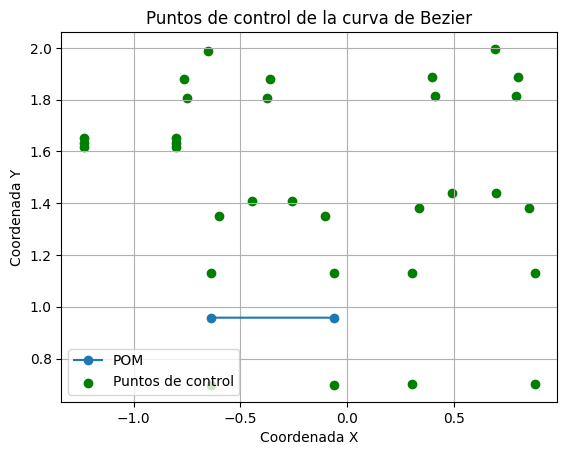

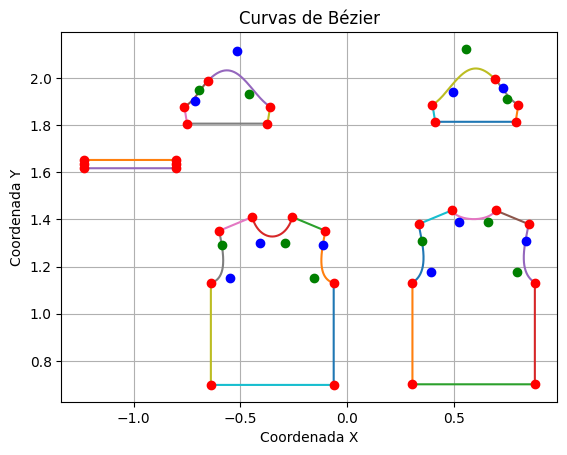

In [11]:
#1. HOW POM AFFECT BEZIER CONTROL POINTS: SEWLINE

# x : Slider value
#f(x) : return  NEW POSITIONS POINTS WITH DISPLACEMENT

# DIBUJAR
positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in bezier_2d for point in piece['sewLine']])
plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')

# Graficar los puntos
plt.scatter(positions_array[:, 0], positions_array[:, 1], color='green', label='Puntos de control')

# Mostrar la gráfica
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de control de la curva de Bezier')
plt.legend()
plt.grid(True)
plt.show()


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

def plot_bezier_curves(bezier_2d):
    # Función para calcular el punto en la curva de Bézier
    def bezier(t, P0, P1=None, P2=None, P3=None):
        if P1 is None or P2 is None:
            # Si solo hay dos puntos, calcula la interpolación lineal
            return [(1-t)*P0[i] + t*P3[i] for i in range(2)]
        else:
            # Si hay cuatro puntos, calcula la curva de Bézier
            return [(1-t)**3 * P0[i] + 3 * (1-t)**2 * t * P1[i] + 3 * (1-t) * t**2 * P2[i] + t**3 * P3[i] for i in range(2)]

    # Crear figura y ejes una vez
    plt.figure()
    ax = plt.gca()
    all_curves_points = []

    # Iterar sobre cada elemento en bezier_2d
    for bezier_data in bezier_2d:
        sewLine = bezier_data['sewLine']
        
        # Generar valores de t (parámetro)
        t_values = np.linspace(0, 1, 2000)

        # Iterar sobre cada par de puntos en sewLine
        for i in range(len(sewLine) - 1):
            P0 = [sewLine[i]['position']['x'], sewLine[i]['position']['y']]
            P3 = [sewLine[i+1]['position']['x'], sewLine[i+1]['position']['y']]
            
            if 'control1' in sewLine[i] and 'control2' in sewLine[i]:
                P1 = [sewLine[i]['control1']['x'], sewLine[i]['control1']['y']]
                P2 = [sewLine[i]['control2']['x'], sewLine[i]['control2']['y']]
            else:
                P1 = None
                P2 = None
            
            curve_points = np.array([bezier(t, P0, P1, P2, P3) for t in t_values])
            all_curves_points.append(curve_points)

            ax.plot(curve_points[:,0], curve_points[:,1], label=f'Curva {i+1} de Bézier')

        # Unir el último punto con el primero
        P0_last = [sewLine[0]['position']['x'], sewLine[0]['position']['y']]
        P3_first = [sewLine[-1]['position']['x'], sewLine[-1]['position']['y']]

        if 'control1' in sewLine[-1] and 'control2' in sewLine[-1]:
            P2_first = [sewLine[-1]['control1']['x'], sewLine[-1]['control1']['y']]
            P1_first = [sewLine[-1]['control2']['x'], sewLine[-1]['control2']['y']]
        else:
            P1_first = None
            P2_first = None

        # Verificamos si hay puntos de control y los incluimos en el cálculo
        if P1_first is not None and P2_first is not None:
            curve_points = np.array([bezier(t, P0_last, P1_first, P2_first, P3_first) for t in t_values])
        else:
            curve_points = np.array([bezier(t, P0_last, None, None, P3_first) for t in t_values])
        all_curves_points.append(curve_points)

        ax.plot(curve_points[:,0], curve_points[:,1], label=f'Curva cerrada de Bézier')
        # Añadir puntos de control y primeros y últimos puntos
        for i, point in enumerate(sewLine):
            ax.plot(point['position']['x'], point['position']['y'], 'ro', label=f'Punto {i}')
            if 'control1' in point:
                ax.plot(point['control1']['x'], point['control1']['y'], 'go', label=f'Control 1 {i}')
            if 'control2' in point:
                ax.plot(point['control2']['x'], point['control2']['y'], 'bo', label=f'Control 2 {i}')

    # Personalizar la leyenda
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Configurar ejes y etiquetas
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.set_title('Curvas de Bézier')
    ax.grid(True)

    # Mostrar la gráfica
    plt.show()
    return all_curves_points

# Llamar a la función para graficar las curvas de Bézier
all_curve_points = plot_bezier_curves(bezier_2d)





#print(len(points_inside_array))


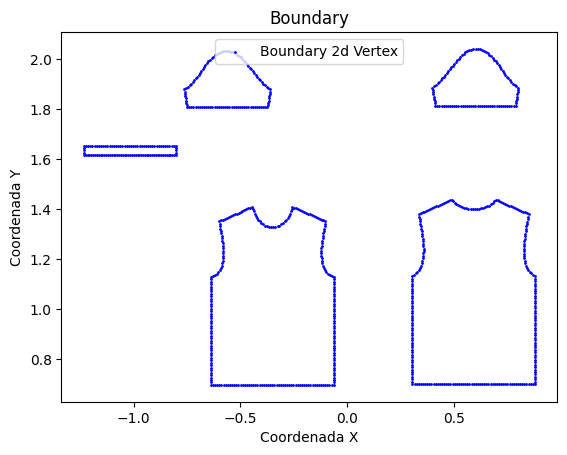

In [12]:
boundary_curves= np.concatenate(all_curve_points, axis=0)

points_inside = []

# Umbral de distancia
threshold = 0.001  # Puedes ajustar este valor según tus necesidades

# Iterar sobre los objetos Coordinates en pieces_2d
for coord in pieces_2d:
    # Coordenadas x e y del objeto Coordinates
    x = coord.x
    y = coord.y
    
    # Calcular la distancia euclidiana entre el punto (x, y) y cada punto en boundary_curves
    distances = np.linalg.norm(boundary_curves - np.array([x, y]), axis=1)
    
    # Verificar si alguna de las distancias es menor que el umbral
    if any(distances < threshold):
        points_inside.append((x, y))

# Convertir points_inside a un array NumPy para facilitar la manipulación
points_inside_array = np.array(points_inside)
# Extraer las coordenadas x e y de los puntos dentro de points_inside_array
x_inside = points_inside_array[:, 0]
y_inside = points_inside_array[:, 1]

# Dibujar los puntos
plt.scatter(x_inside, y_inside, color='blue', label='Boundary 2d Vertex',s=1)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Boundary')
plt.legend()
plt.show()


In [13]:
import numpy as np

# Función para calcular los puntos de la curva de Bezier
def bezier(t, P0, P1, P2, P3):
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

# Función para encontrar el segmento y el parámetro t de un punto en las curvas de Bézier
def find_segment_and_t(all_curve_points, point):
    """
    Encuentra el segmento y el parámetro t de un punto en las curvas de Bézier.

    Args:
    all_curve_points (list): Lista de puntos de las curvas de Bézier.
    point (list): Coordenadas [x, y] del punto a buscar.

    Returns:
    tuple: El índice del segmento y el valor de t correspondiente.
    """
    # Inicializar las variables para el punto más cercano y su distancia mínima
    closest_point = None
    min_distance = float('inf')
    segment_index = -1
    
    # Iterar sobre cada conjunto de puntos de las curvas de Bézier
    for index, curve_points in enumerate(all_curve_points):
        # Calcular la distancia euclidiana entre el punto dado y cada punto en la curva de Bézier
        distances = np.linalg.norm(curve_points - point, axis=1)
        
        # Encontrar el punto más cercano en la curva de Bézier
        closest_index = np.argmin(distances)
        closest_distance = distances[closest_index]
        
        # Si la distancia al punto más cercano es menor que la mínima registrada hasta ahora, actualizar
        if closest_distance < min_distance:
            closest_point = curve_points[closest_index]
            min_distance = closest_distance
            segment_index = index
    
    # Calcular el valor de t correspondiente al punto más cercano
    if closest_point is not None:
        t_value = np.where(np.all(all_curve_points[segment_index] == closest_point, axis=1))[0][0] / (len(all_curve_points[segment_index]) - 1)
        return segment_index, t_value
    else:
        return None, None


# Lista para almacenar los segmentos y los parámetros t para todos los puntos del borde
boundary_vertex_segment_t = []

# Iterar sobre todos los puntos del borde
for point_to_find in points_inside_array:
    # Llamar a la función para encontrar el segmento y el parámetro t del punto
    segment_index, t_value = find_segment_and_t(all_curve_points, point_to_find)
    
    # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
    if segment_index is not None:
        boundary_vertex_segment_t.append((point_to_find, segment_index, t_value))

# Mostrar los resultados
for idx, (point_to_find, segment_index, t_value) in enumerate(boundary_vertex_segment_t):
    print(f"Punto {idx}: {point_to_find} está en el segmento {segment_index} con un valor de t = {t_value}.")
print(boundary_vertex_segment_t)

Punto 0: [-0.80246975  1.65215421] está en el segmento 0 con un valor de t = 1.0.
Punto 1: [-0.81246974  1.65215421] está en el segmento 1 con un valor de t = 0.02301150575287644.
Punto 2: [-0.82246975  1.65215421] está en el segmento 1 con un valor de t = 0.04652326163081541.
Punto 3: [-0.83246975  1.65215421] está en el segmento 1 con un valor de t = 0.06953476738369184.
Punto 4: [-0.84246976  1.65215421] está en el segmento 1 con un valor de t = 0.09304652326163082.
Punto 5: [-0.85246975  1.65215421] está en el segmento 1 con un valor de t = 0.11605802901450725.
Punto 6: [-0.86246976  1.65215421] está en el segmento 1 con un valor de t = 0.13956978489244623.
Punto 7: [-0.87246976  1.65215421] está en el segmento 1 con un valor de t = 0.16258129064532267.
Punto 8: [-0.88246975  1.65215421] está en el segmento 1 con un valor de t = 0.18609304652326164.
Punto 9: [-0.89246976  1.65215421] está en el segmento 1 con un valor de t = 0.20910455227613806.
Punto 10: [-0.90246975  1.65215421] 

[[-0.80246975  1.65215421]
 [-0.81246974  1.65215421]
 [-0.82246975  1.65215421]
 ...
 [ 0.79531061  1.85891904]
 [ 0.79689065  1.86789412]
 [ 0.79847071  1.87686921]]
[{'garmentPiece_id': '661c20b39565d2501311a089', 'sewLine': [{'position': {'x': -0.8024697529775202, 'y': 1.634628211846337}, 'type': 'LINE', '_id': '6601616da0216e4eb0a5a3b9'}, {'position': {'x': -0.8024697529775202, 'y': 1.652154212584481}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3ba'}, {'position': {'x': -1.2324697601300776, 'y': 1.652154212584481}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3bb'}, {'position': {'x': -1.2324697601300776, 'y': 1.634628211846337}, 'type': 'LINE', '_id': '6601616da0216e4eb0a5a3bc'}, {'position': {'x': -1.2324697601300776, 'y': 1.6171022111081932}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3bd'}, {'position': {'x': -0.8024697529775202, 'y': 1.6171022111081932}, 'type': 'SEWING', '_id': '6601616da0216e4eb0a5a3be'}]}
 {'garmentPiece_id': '661c20b39565d2501311a09d', 'sewLine'

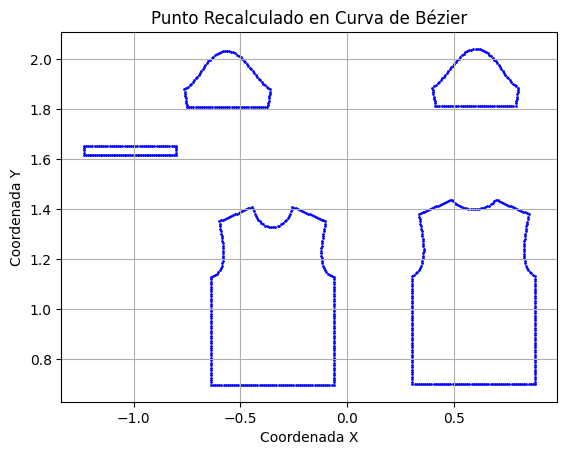

In [14]:
print(points_inside_array)
print(bezier_2d)

# Definir puntos del borde de la malla en funcion de la sewLine

# Función para recalcular un punto en la curva de Bezier dado un segmento y un valor de t
def recalculate_point(all_curve_points, segment_index, t_value):

    # Obtener los puntos del segmento dado
    curve_points = all_curve_points[segment_index]
    
    # Calcular el índice correspondiente al valor de t
    index = int(t_value * (len(curve_points) - 1))
    
    # Devolver las coordenadas del punto en ese índice
    return curve_points[index]

recalculated_points = []
for point_to_find in boundary_vertex_segment_t:
    # Llamar a la función para encontrar el segmento y el parámetro t del punto
    segment_index=point_to_find[1]
    t_value=point_to_find[2]
    recalculated_point = recalculate_point(all_curve_points, segment_index, t_value)

    # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
    if segment_index is not None:
        recalculated_points.append(recalculated_point)

# Recalcular el punto usando el segmento y el valor de t

print(f"El punto recalculado es: {recalculated_points}")
print(len(recalculated_points))
# Pintar los puntos recalculados
for point in recalculated_points:
    plt.scatter(point[0], point[1], color='blue', label='Punto Recalculado',s=1)


    # Configuraciones adicionales del gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Punto Recalculado en Curva de Bézier')
plt.grid(True)
    
    # Mostrar el gráfico
plt.show()


In [15]:
import numpy as np
bezier_curve = np.concatenate(all_curve_points, axis=0)

def find_intersection_points(bezier_curve, ray, orientation):
    intersection_points = []
    if(orientation=='horizontal'):

        for i in range(len(bezier_curve) - 1):
            # Check for intersection between line segment and ray
            y1, y2 = bezier_curve[i][1], bezier_curve[i+1][1]
            if (y1 >= ray and y2 <= ray) or (y1 <= ray and y2 >= ray):
                # Interpolate x value at intersection point
                t = (ray - y1) / (y2 - y1)
                intersection_x = bezier_curve[i][0] + t * (bezier_curve[i+1][0] - bezier_curve[i][0])
                intersection_points.append((intersection_x, ray))
        return intersection_points
    else:     
        for i in range(len(bezier_curve) - 1):
        # Obtener coordenadas x de los puntos del segmento
            x1, x2 = bezier_curve[i][0], bezier_curve[i+1][0]
            
            # Verificar si el segmento intersecta con la línea vertical
            if (x1 >= ray and x2 <= ray) or (x1 <= ray and x2 >= ray):
                # Interpolar el valor y en el punto de intersección
                t = (ray - x1) / (x2 - x1)
                intersection_y = bezier_curve[i][1] + t * (bezier_curve[i+1][1] - bezier_curve[i][1])
                intersection_points.append((ray, intersection_y))
        return intersection_points

def closest_points_to_P(intersection_points, P, orientation):
    if(orientation=='horizontal'):
        left_point, right_point = None, None
        min_dist_left, min_dist_right = float('inf'), float('inf')
        for point in intersection_points:
            dist = np.linalg.norm(np.array(P) - np.array(point))
            if point[0] < P[0] and dist < min_dist_left:
                left_point = point
                min_dist_left = dist
            elif point[0] > P[0] and dist < min_dist_right:
                right_point = point
                min_dist_right = dist

        return left_point, right_point
    else:
        above_point, below_point = None, None
        min_dist_above, min_dist_below = float('inf'), float('inf')
        for point in intersection_points:
            dist = np.linalg.norm(np.array(P) - np.array(point))
            # Verificar si el punto está arriba o abajo de P en el eje y
            if point[1] > P[1] and dist < min_dist_above:
                above_point = point
                min_dist_above = dist
            elif point[1] < P[1] and dist < min_dist_below:
                below_point = point
                min_dist_below = dist
        return above_point, below_point


def nearest_indices(array_nearest, array_points):
    indices = []
    for point in array_nearest:
        # Calcular las distancias entre el punto actual y todos los puntos en array_points
        distances = np.linalg.norm(array_points - point, axis=1)
        # Encontrar el índice del punto más cercano
        nearest_index = np.argmin(distances)
        indices.append(nearest_index)
    return indices


def boundary_points(intersection_points, point_left):
    # Calcular las distancias euclidianas entre los puntos de intersección y point_left
    distances = np.linalg.norm(intersection_points - np.array([point_left[0], point_left[1]]), axis=1)
    
    # Obtener los índices de los puntos más cercanos (ordenados de menor a mayor distancia)
    nearest_indices = np.argsort(distances)
    
    # Tomar los dos puntos más cercanos
    nearest_boundary_points = [intersection_points[i] for i in nearest_indices[:2]]
    
    return nearest_boundary_points


def calculate_angle(point1, point2):
    """
    Calcula el ángulo entre dos puntos y el eje x.
    """
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    return np.arctan2(dy, dx)

def reorder_indices(reference_points, P):
    """
    Reordena los índices de los puntos de referencia en función del ángulo con el punto P.
    """
    angles = [calculate_angle(P, point) for point in reference_points]
    indices = np.argsort(angles)
    return indices




def is_convex_quadrilateral(points):
    """
    Verifica si los puntos forman un cuadrilátero convexo.
    """
    def cross_product(p1, p2, p3):
        """
        Calcula el producto cruzado de dos vectores formados por los puntos p1, p2, y p3.
        """
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

    n = len(points)
    for i in range(n):
        # Calcula el producto cruzado para cada tripleta de puntos adyacentes
        j = (i + 1) % n
        k = (i + 2) % n
        cross = cross_product(points[i], points[j], points[k])
        # Si el producto cruzado es negativo, indica que los puntos no están en orden convexo
        if cross < 0:
            return False
    return True


def calculate_weights(points, P):
    x_p, y_p = P
    weights = []
    for x, y in points:
        distance = np.sqrt((x - x_p)**2 + (y - y_p)**2)
        weights.append(1 / distance)  # Inverse distance weighting
    total_weight = sum(weights)
    return [w / total_weight for w in weights]  # Normalize weights
    """
    A = points[0]
    B = points[1]
    C = points[2]
    v0 = C - A
    v1 = B - A
    v2 = P - A

    # Calculate dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    # Compute barycentric coordinates
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    w = 1 - u - v
    return u, v, w
        """

def bilinear_interpolation(points, weights):
    interpolated_x = sum(w * x for w, (x, _) in zip(weights, points))
    interpolated_y = sum(w * y for w, (_, y) in zip(weights, points))
    """
    u=weights[0]
    v=weights[1]
    w=weights[2]

    weighted_sum = u * points[0] + v * points[1] + w * points[2]

    
    return weighted_sum[0], weighted_sum[1]
    """
    return interpolated_x,interpolated_y


def vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array):
    #plt.figure(figsize=(8, 6))

    if orientation == 'horizontal':
        ray = P[1]
        #plt.axhline(y=ray, color='gray', linestyle='--', label='Ray')

    else:
        ray = P[0]
        #plt.axvline(x=ray, color='gray', linestyle='--', label='Ray')

    #plt.scatter(*zip(*points_inside_array), color='blue',s=1, label='Points Inside')
    #plt.scatter(*zip(P), color='green', label='P')

    intersection_points = find_intersection_points(bezier_curve, ray, orientation)

    #plt.scatter(*zip(*intersection_points), color='red',s=5, label='Intersection Points')
    #plt.plot(*zip(*bezier_curve), color='black', label='Bezier Curve')

    left_point, right_point = closest_points_to_P(intersection_points, P, orientation)

    #plt.scatter(*zip(left_point), color='orange', label='Left Point')
    #plt.scatter(*zip(right_point), color='purple', label='Right Point')

    nearest_boundary_points_left = boundary_points(points_inside_array, left_point)
    nearest_boundary_points_right = boundary_points(points_inside_array, right_point)
    nearest_boundary_points = nearest_boundary_points_left + nearest_boundary_points_right
    #plt.scatter(*zip(*nearest_boundary_points_left), color='cyan', label='Nearest Boundary Points (Left)')
    #plt.scatter(*zip(*nearest_boundary_points_right), color='magenta', label='Nearest Boundary Points (Right)')

    nearest_indices_of_points = nearest_indices(nearest_boundary_points, points_inside_array)

    reordered_indices = reorder_indices(points_inside_array[nearest_indices_of_points], P)

    reordered_nearest_indices_of_points = [nearest_indices_of_points[i] for i in reordered_indices]


    weights = calculate_weights(points_inside_array[reordered_nearest_indices_of_points], P)
    #plt.xlabel('X')
    #plt.ylabel('Y')
    #plt.title('Intersection Points and Nearest Boundary Points')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(*zip(*intersection_points), color='red',s=5, label='Intersection Points')
    plt.scatter(*zip(P), color='green', label='P')
    plt.scatter(*zip(*nearest_boundary_points_left), color='cyan', label='Nearest Boundary Points (Left)')
    plt.scatter(*zip(*nearest_boundary_points_right), color='magenta', label='Nearest Boundary Points (Right)')
    plt.scatter(*zip(left_point), color='orange', label='Left Point')
    plt.scatter(*zip(right_point), color='purple', label='Right Point')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Intersection Points and Nearest Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    return weights, reordered_nearest_indices_of_points

# Example usage:
#points_array = [(-0.35, 1.35),(-0.20043471708731297, 1.20109981477757)]   # Point on ray


points_array = []

for piece_data in pieces_positions2d:
    position2d = piece_data['position2D']
    for i in range(0, len(position2d), 2):
        x = position2d[i]
        y = position2d[i + 1]
        point = [x, y]
        if not np.any(np.all(points_inside_array == point, axis=1)):
            points_array.append(point)

weights_array = []
nearest_boundary_vertex_array = []
P_recalculated_array = []
orientation='horizontal'
# Iterate over each point
for P in points_array:
    # Compute weights and nearest boundary vertices
    weights, nearest_boundary_vertex = vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array)
    #print(points_inside_array[nearest_boundary_vertex])
    # Perform bilinear interpolation
    P_recalculated = bilinear_interpolation(points_inside_array[nearest_boundary_vertex], weights)
    
    # Append results to arrays
    weights_array.append(weights)
    nearest_boundary_vertex_array.append(nearest_boundary_vertex)
    P_recalculated_array.append(P_recalculated)
    #print("Weights:", weights)

    #print("Original Point P:", (P[0], P[1]),"Interpolated position at point P:", (P_recalculated[0], P_recalculated[1]))
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(P[0], P[1], color='blue', label='Puntos originales')
    plt.scatter(P_recalculated[0], P_recalculated[1], color='blue', label='Puntos recalculated')
    plt.plot(*zip(*bezier_curve), color='black', label='Bezier Curve')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Intersection Points and Nearest Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

#P_recalculated_array = recalculate_vertex_points(points_inside_array,nearest_boundary_vertex_array,weights_array)


# Plotting
# Plot P, left_point, right_point

# Plot nearest boundary points




print(nearest_boundary_vertex_array)

In [ ]:
# Extrae las coordenadas x e y de los puntos originales y recalculados
original_x = [point[0] for point in points_array]
original_y = [point[1] for point in points_array]

# Dibuja los puntos originales y recalculados
plt.scatter(original_x, original_y, color='blue', label='Puntos originales')
plt.plot(*zip(*bezier_curve), color='black', label='Bezier Curve')

plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos originales y recalculados')
plt.legend()
plt.grid(True)
plt.show()
recalculated_x = [point[0] for point in P_recalculated_array]
recalculated_y = [point[1] for point in P_recalculated_array]
plt.plot(*zip(*bezier_curve), color='black', label='Bezier Curve')

# Dibuja los puntos originales y recalculados
plt.scatter(recalculated_x, recalculated_y, color='orange', label='Puntos recalculados')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos originales y recalculados')
plt.legend()
plt.grid(True)
plt.show()
print(weights[0])
print(nearest_boundary_vertex_array[0])
print(P_recalculated_array)

In [ ]:
import math
import copy


def get_sewline_by_id(id,bezier):
    for piece in bezier:
        if piece['garmentPiece_id'] == id:
            sewLine = piece['sewLine']
            return sewLine
    return None

def update_sewline_in_pieces(sewline, id,bezier):
    # Hacer una copia de bezier_2d
    for piece in bezier:
        if piece['garmentPiece_id'] == id:
            piece['sewLine'] = sewline



def calcular_desplazamiento(p1,p2, orientacion, diferencia_longitud):
    ajuste_mitad =  diferencia_longitud / 2

    if orientacion == 1:
        ajuste_mitad = diferencia_longitud

    desplazamiento_x = ajuste_mitad
    desplazamiento_y = ajuste_mitad

    if orientacion == 0:

        desplazamiento_y = 0
    elif orientacion == 1:
        desplazamiento_x = 0
        
    elif orientacion == 2:
      dx = p2.x - p1.x
      dy = p2.y - p1.y
      dist = math.sqrt(dx * dx + dy * dy)

      ux = math.abs(dx / dist)
      uy = dy / dist


      direccionOriginal = { x: ux, y: uy }

      desplazamientoX = direccionOriginal.x * ajuste_mitad
      desplazamientoY = direccionOriginal.y * ajuste_mitad

    return desplazamiento_x, desplazamiento_y



def desplazar_puntos_sewline_en_pom(sewline, indices_desplazar, despX, despY):
    for idx in indices_desplazar:
        if 0 <= idx < len(sewline):
            point = sewline[idx]
            #print(point)
            
            # Desplazar el punto principal
            point['position']['x'] -= despX
            point['position']['y'] -= despY

            # Si el punto tiene puntos de control, también desplazarlos
            #if 'control1' in point:
            #    point['control1']['x'] -= despX
            #    point['control1']['y'] -= despY
            #if 'control2' in point:
            #    point['control2']['x'] -= despX
            #    point['control2']['y'] -= despY






slider_Value= np.sqrt((pom_C1.x - pom_C0.x)**2 + (pom_C1.y - pom_C0.y)**2) #0.57 -> valor Slider 57cm
newSliderValue = 0.9   #Ahora quiero que sea 60cm
diferencia_longitud = newSliderValue - slider_Value
bezier_2d_copy = copy.deepcopy(bezier_2d)




recalculated_boundary_points = []
recalculated_vertex_points = []




bezier_Path = copy.deepcopy(pieces_bezierPath)

def f(dif,bezierPath):
    despX, despY = calcular_desplazamiento(pom_C0,pom_C1,poms[0]['orientation'],dif)
    # Desplazar los puntos de la sewline del POM
    sewLine_POM_0 = get_sewline_by_id(poms[0]['POM'][0][0]['piece'],bezierPath)
    desplazar_puntos_sewline_en_pom(sewLine_POM_0, poms[0]['POM'][0][0]['nodes']['sewLine'],despX,despY)
    update_sewline_in_pieces(sewLine_POM_0, poms[0]['POM'][0][0]['piece'],bezierPath)

    # Desplazar los puntos de la sewline del POM
    sewLine_POM_1 = get_sewline_by_id(poms[0]['POM'][1][0]['piece'],bezierPath)
    desplazar_puntos_sewline_en_pom(sewLine_POM_1, poms[0]['POM'][1][0]['nodes']['sewLine'],-despX,-despY)
    update_sewline_in_pieces(sewLine_POM_1, poms[0]['POM'][1][0]['piece'],bezierPath)
    
    all_curve_points=plot_bezier_curves(bezierPath)
    for point_to_find in boundary_vertex_segment_t:
        # Llamar a la función para encontrar el segmento y el parámetro t del punto
        segment_index=point_to_find[1]
        t_value=point_to_find[2]
        recalculated_point = recalculate_point(all_curve_points, segment_index, t_value)

        # Si se encuentra el punto en alguna curva de Bézier, almacenar el resultado
        if segment_index is not None:
            recalculated_boundary_points.append(recalculated_point)




    return bezierPath
    #return new_2d_vertex_positions

recalculated_vertex_points = recalculate_vertex_points(np.array(recalculated_boundary_points),nearest_boundary_vertex_array,weights_array)

new_bezier_2d_positions = f(diferencia_longitud,bezier_Path)


weights_array = []
nearest_boundary_vertex_array = []
P_recalculated_array = []
orientation='horizontal'

for P in points_array:
    # Compute weights and nearest boundary vertices
    weights, nearest_boundary_vertex = vertex_weights_nearest_points(P, orientation, bezier_curve, points_inside_array)
    # Append results to arrays
    weights_array.append(weights)
    nearest_boundary_vertex_array.append(nearest_boundary_vertex)

# Iterate over each point
for i, P in np.array(recalculated_boundary_points):

    P_recalculated = bilinear_interpolation(np.array(recalculated_boundary_points)[nearest_boundary_vertex[i]], weights[i])

    P_recalculated_array.append(P_recalculated)



recalculated_vertex_points_x = [point[0] for point in recalculated_vertex_points]
recalculated_vertex_points_y = [point[1] for point in recalculated_vertex_points]

# Dibuja los puntos originales y recalculados
plt.scatter(recalculated_vertex_points_x, recalculated_vertex_points_y, color='orange', label='Puntos recalculados')



#DIBUJAR
old_positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in bezier_2d for point in piece['sewLine']])
old_control_points_array = np.array([(point['control1']['x'], point['control1']['y']) for piece in bezier_2d for point in piece['sewLine'] if 'control1' in point] +
                                [(point['control2']['x'], point['control2']['y']) for piece in bezier_2d for point in piece['sewLine'] if 'control2' in point])
plt.scatter(old_control_points_array[:, 0], old_control_points_array[:, 1], color='black', label='Old Puntos de control', marker='o', facecolors='none')

# Graficar los puntos
plt.scatter(old_positions_array[:, 0], old_positions_array[:, 1], color='black', label='Old Puntos de control')

new_positions_array = np.array([(point['position']['x'], point['position']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine']])
plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')
# Obtener los puntos de control de bezier_2d
new_control_points_array = np.array([(point['control1']['x'], point['control1']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine'] if 'control1' in point] +
                                [(point['control2']['x'], point['control2']['y']) for piece in new_bezier_2d_positions for point in piece['sewLine'] if 'control2' in point])

for point in recalculated_boundary_points:
    plt.scatter(point[0], point[1], color='blue',s=1)

# Pintar los puntos de control
plt.scatter(new_control_points_array[:, 0], new_control_points_array[:, 1], color='green', label='New Puntos de control', marker='o', facecolors='none')
plt.scatter(new_positions_array[:, 0], new_positions_array[:, 1], color='green', label='New Puntos de control')

plt.scatter([position.x for position in pieces_2d], 
            [position.y for position in pieces_2d], 
            color='red',s=1, label='Vertex 2d Pieces')
# Mostrar la gráfica
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de control de la curva de Bezier')
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(recalculated_vertex_points_x, recalculated_vertex_points_y, color='orange', label='Puntos recalculados')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Puntos de control de la curva de Bezier')
plt.legend()
plt.grid(True)
plt.show()
